# Homework 1
## Section 1: Liver Data

We are interested in finding a variable that can help predict possible liver patients at different ages. In many countries, it is very expensive to perform medical tests, especially where blood or other biohazardous materials are present. We will use this patient data that contains the levels of various proteins in the blood in order to see if a certain protein is more effective at determining if a patient has liver disease, in order to help cut costs in other countries where hepatitis is rampant. 

We will start by importing the necessary Python modules.

In [1]:
#Import the basic packages
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import collections
import sqlite3
import seaborn as sns
import numpy as np
from scipy import stats
import json
from datetime import timedelta  
import csv
import time
from pandas.io.json import json_normalize #package for flattening json in pandas df

We have found a dataset in sql form and will need to import it. Luckily it is only one table so no joins will be necessary.

In [2]:
#Import the SQL Database via Sqlite3
sql_liver = sqlite3.connect(r"C:\Users\zgeorge\Dropbox (CMN Hospitals)\George\School\Fall 2018\Applied Machine Learning\practice_python\Homework 1\LiverData.db")

In [3]:
#Read the imported data into a Dataframe
liver_df = pd.read_sql_query("select * from indian_liver_patient;", con=sql_liver)
#View first 5 rows, along with column headers and index
liver_df.head(5)

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.9,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.4,1


We have several variables that are found using blood tests. We also have the age, gender, and what type of patient the data comes from. Lets make sure that the type of patient is legible for future analysis.

In [4]:
#Change the Dataset code from 1 to Liver Patient and from 2 to Non-Liver Patient
liver_df['Dataset'] = liver_df['Dataset'].map({1 : 'Liver Patient', 2 : 'Non-Liver Patient'})
#View first 5 rows, along with column headers and index
liver_df.head(5)

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.9,Liver Patient
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,Liver Patient
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,Liver Patient
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1,Liver Patient
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.4,Liver Patient


Before we clean the data, it is important to define what type of data each variable should be. We will start by checking what they have been read in as.

In [5]:
#View what types of data each column contains
liver_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
Age                           583 non-null int64
Gender                        583 non-null object
Total_Bilirubin               583 non-null float64
Direct_Bilirubin              583 non-null float64
Alkaline_Phosphotase          583 non-null int64
Alamine_Aminotransferase      583 non-null int64
Aspartate_Aminotransferase    583 non-null int64
Total_Protiens                583 non-null float64
Albumin                       583 non-null float64
Albumin_and_Globulin_Ratio    583 non-null object
Dataset                       583 non-null object
dtypes: float64(4), int64(4), object(3)
memory usage: 50.2+ KB


Its clear that not all of them are correct and that the column headings are very long. That will affect our ability to plot them. Let's fix that!

In [6]:
#Change the necessary columns to category and numeric
liver_df[['Gender','Dataset']] = liver_df[['Gender','Dataset']].astype('category')
liver_df[['Albumin_and_Globulin_Ratio']] = liver_df[['Albumin_and_Globulin_Ratio']].apply(pd.to_numeric)
#Renaming columns to shorten them for better fit on plots
liver_df.rename(columns={'Alkaline_Phosphotase':'Alkaline_Phosph','Alamine_Aminotransferase':'Alamine_Aminotrans','Aspartate_Aminotransferase':'Aspartate_Aminotrans','Albumin_and_Globulin_Ratio':'Albumin:Globulin'}, inplace=True)

We now want to ensure that any outliers are removed. Even in the case of accurately collected data, the outliers could make our model incorrect. So we are going to visually display our data and see what kind of outliers we have.

Text(0.5,1,'Search for Outliers')

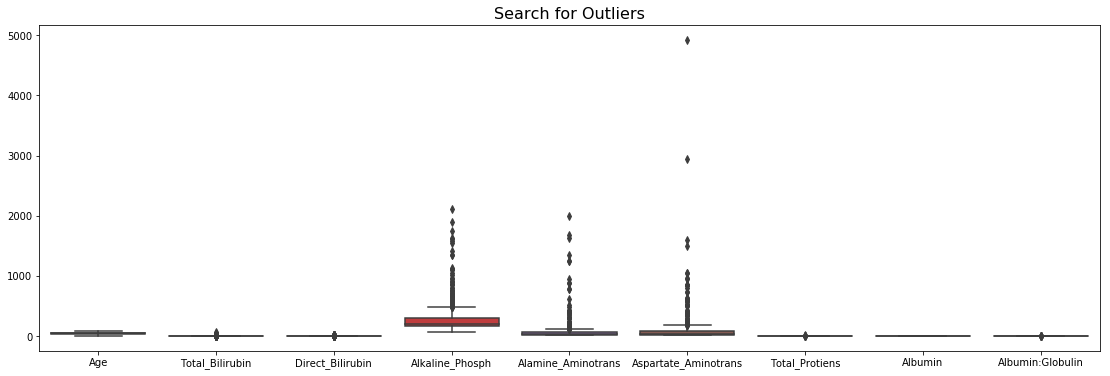

In [7]:
#Create box and whisker plot to see outliers; set plot size and title
plt.figure(figsize=(19,6))
bboxs = sns.boxplot(data=liver_df)
plt.title('Search for Outliers',fontsize=16)

Its clear that we have far too many outliers, however, if we were to remove anything outside of three times the standard devation, we would have very little data left, and that would also be problematic as unhealthy liver patients should have levels outside the normal, so we will be removing anything outside of the 99th percentile in the most variable two columns, just to clean up the data a bit and then redisplay our box and whisker plot.

Text(0.5,1,'Search for Outliers')

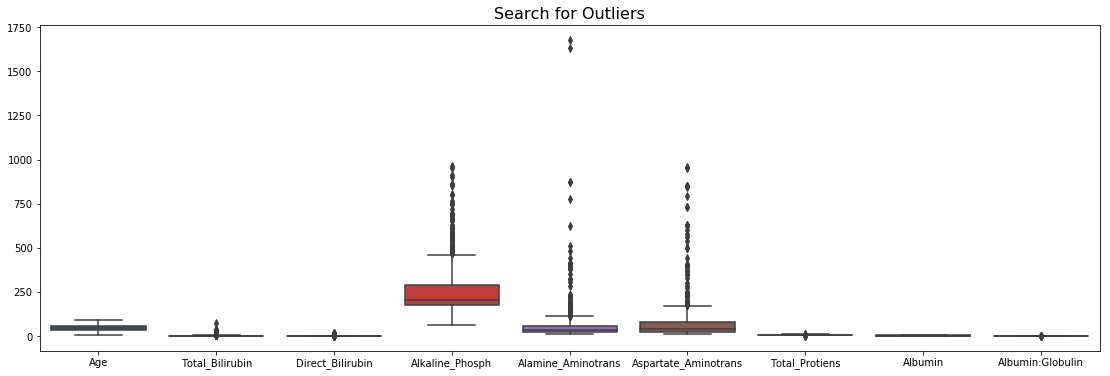

In [8]:
#Remove anything outside the 99th percentile for Aspartate Aminotransferase and Alkaline Phosphatase
qAsp = liver_df['Aspartate_Aminotrans'].quantile(0.99)
liver_df = liver_df[liver_df['Aspartate_Aminotrans'] < qAsp]
qAlk = liver_df['Alkaline_Phosph'].quantile(0.99)
liver_df = liver_df[liver_df['Alkaline_Phosph'] < qAsp]
#Display the same Plot as before with the outliers removed
plt.figure(figsize=(19,6))
bboxs = sns.boxplot(data=liver_df)
plt.title('Search for Outliers',fontsize=16)

That looks much better now! Not perfect, but that would only be the case with healthy patients, hopefully! Next we want describe what the data looks like.

In [9]:
#Describe the dataset
liver_df.describe()

,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosph,Alamine_Aminotrans,Aspartate_Aminotrans,Total_Protiens,Albumin,Albumin:Globulin
count,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,560.000000
mean,44.574468,3.099291,1.386879,259.971631,67.815603,87.585106,6.495390,3.156738,0.953036
std,16.141463,6.048246,2.710752,147.985535,132.601279,139.286056,1.089664,0.796199,0.319971
min,4.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000
25%,33.000000,0.800000,0.200000,175.000000,23.000000,25.000000,5.800000,2.600000,0.700000
50%,45.000000,1.000000,0.300000,206.000000,34.000000,40.500000,6.600000,3.100000,0.985000
75%,57.000000,2.400000,1.200000,290.000000,59.000000,82.250000,7.200000,3.800000,1.100000
max,90.000000,75.000000,19.700000,962.000000,1680.000000,960.000000,9.600000,5.500000,2.800000


It appears we have some nulls in the Albumin:Globulin column, so we are going to remove those.

In [10]:
liver_df = liver_df.dropna(how='any',axis=0) 

Now that we know that our dataset is clean, we want to see if there is any strong correlations so that we can test those variables, and also if there is any perfect covariations, which would mean we need to delete that variable.

In [11]:
#Describe the correlation between variables
liver_df.corr()

,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosph,Alamine_Aminotrans,Aspartate_Aminotrans,Total_Protiens,Albumin,Albumin:Globulin
Age,1.000000,0.024909,0.017329,0.029663,-0.074131,-0.038014,-0.187535,-0.262727,-0.210918
Total_Bilirubin,0.024909,1.000000,0.863458,0.205119,0.120996,0.247050,-0.000790,-0.214893,-0.196321
Direct_Bilirubin,0.017329,0.863458,1.000000,0.233909,0.142882,0.275476,0.007336,-0.222822,-0.189961
Alkaline_Phosph,0.029663,0.205119,0.233909,1.000000,0.103279,0.115159,0.007571,-0.138268,-0.225169
Alamine_Aminotrans,-0.074131,0.120996,0.142882,0.103279,1.000000,0.775067,-0.022399,-0.010430,-0.004610
Aspartate_Aminotrans,-0.038014,0.247050,0.275476,0.115159,0.775067,1.000000,-0.033959,-0.113682,-0.101269
Total_Protiens,-0.187535,-0.000790,0.007336,0.007571,-0.022399,-0.033959,1.000000,0.783384,0.231609
Albumin,-0.262727,-0.214893,-0.222822,-0.138268,-0.010430,-0.113682,0.783384,1.000000,0.684475
Albumin:Globulin,-0.210918,-0.196321,-0.189961,-0.225169,-0.004610,-0.101269,0.231609,0.684475,1.000000


There aren't any red flags, but there also aren't any interesting correlations. We know that those with liver disease will have different baseline levels from those that are healthy, so let's see what the difference is in the average between the two.

In [12]:
#Display a pivot table with the means of each numeric variable, split by What type of patient
pd.pivot_table(liver_df,index=['Dataset'])

,Age,Alamine_Aminotrans,Albumin,Albumin:Globulin,Alkaline_Phosph,Aspartate_Aminotrans,Direct_Bilirubin,Total_Bilirubin,Total_Protiens
Dataset,,,,,,,,,
Liver Patient,45.977273,82.497475,3.073737,0.920253,280.520202,107.545455,1.815909,3.946465,6.472727
Non-Liver Patient,41.310976,33.506098,3.345732,1.032195,212.396341,40.621951,0.376829,1.107317,6.545122


We are seeing the biggest differences in the Alamine Aminotransferase levels, the Alkaline Phosphatase levels, the Aspartate Aminotransferase levels and the Direct Bilirubin levels. However, we know that men and women should have different baselines. So, let's split out the data by gender as well, and see if any variable becomes a stronger or weaker indicator

In [13]:
#Display a pivot table with the means of each numeric variable, split by What type of patient and the gender
pd.pivot_table(liver_df,index=['Dataset','Gender'])

Age  Alamine_Aminotrans   Albumin  \
Dataset           Gender                                            
Liver Patient     Female  43.000000           55.541176  3.255294   
                  Male    46.790997           89.864952  3.024116   
Non-Liver Patient Female  42.897959           30.102041  3.363265   
                  Male    40.634783           34.956522  3.338261   

                          Albumin:Globulin  Alkaline_Phosph  \
Dataset           Gender                                      
Liver Patient     Female          0.933529       275.211765   
                  Male            0.916624       281.971061   
Non-Liver Patient Female          1.007347       203.755102   
                  Male            1.042783       216.078261   

                          Aspartate_Aminotrans  Direct_Bilirubin  \
Dataset           Gender                                           
Liver Patient     Female             73.952941          1.085882   
                  Male              116.726688          2.015434   
Non-Liver Patient Female             32.183673          0.269388   
                  Male               44.217391          0.422609   

                          Total_Bilirubin  Total_Protiens  
Dataset           Gender                                   
Liver Patient     Female         2.490588        6.702353  
                  Male           4.344373        6.409968  
Non-Liver Patient Female         0.912245        6.608163  
                  Male           1.190435        6.518261

It now becomes obvious that the Aspartate Aminotransferase has the largest difference between sick and healthy livers, when the gender is accounted for. Lets now plot that against age and see if there is a strong difference.

Text(0.5,1,'Aspartate Aminotransferase by Age')

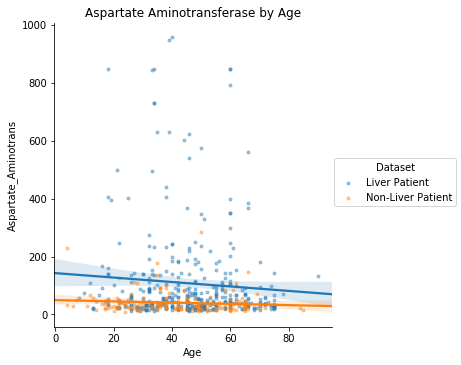

In [14]:
#Display a regression plot by age and amount of Aspartate Aminotransferase in the blood, split by type of patient along with a title
sns.lmplot(data=liver_df,x='Age',y='Aspartate_Aminotrans',hue='Dataset',scatter_kws={'alpha':0.4},markers='.')
plt.title('Aspartate Aminotransferase by Age')

We have success! Although the difference becomes weaker with age, a high level of Aspartate Aminotransferase in the blood at a young age is the best way to check for liver disease if you only have the ability to check for one protien level in the blood. If doctors only have the resources to order one test, the most effective to determine the worth of further tests is the Aspartate Aminotransferase level. With this knowledge, we can help lower medical cost for potential hepatitis patients in other countries.

## Section 2: Android App Data

In today's world of constantly rising startups, one may be interested in what causes an app to fail or succeed. In this case, we will be examining what variables affect the likelihood of an app recieving a high overall rating.

We first will read in our excel that was scraped from the Android Play Store, and converted to a CSV. I then saved it as an excel and imported it into our dataframe.

In [15]:
#Read in the data from an Excel file and display the first two rows
aapps_df = pd.read_excel(r"C:\Users\zgeorge\Dropbox (CMN Hospitals)\George\School\Fall 2018\Applied Machine Learning\practice_python\Homework 1\Android_Data.xlsx")
aapps_df.head(2)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,10000,Free,0,Everyone,Art & Design,2018-01-07 00:00:00,1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,500000,Free,0,Everyone,Art & Design;Pretend Play,2018-01-15 00:00:00,2.0.0,4.0.3 and up


In order to make sure that the data was usable, we are going to modify the Intalls column so that it will be entirely integers, for better analysis.

In [16]:
#Remove any string of "F+" in the Installs column
aapps_df['Installs'].replace({"+": ""})
#Display the top five rows
aapps_df.head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,10000,Free,0,Everyone,Art & Design,2018-01-07 00:00:00,1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,500000,Free,0,Everyone,Art & Design;Pretend Play,2018-01-15 00:00:00,2.0.0,4.0.3 and up
2,"U Launcher Lite â€“ FREE Live Cool Themes, Hid...",ART_AND_DESIGN,4.7,87510,8.7M,5000000,Free,0,Everyone,Art & Design,2018-08-01 00:00:00,1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,50000000,Free,0,Teen,Art & Design,2018-06-08 00:00:00,Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,100000,Free,0,Everyone,Art & Design;Creativity,2018-06-20 00:00:00,1.1,4.4 and up


Before we can analyze the data, we need to clean it. It appears that there are many nulls and so we need to remove those. Before doing so, and knowing that this data was scraped, I want to confirm that there aren't any rows in which the data has been shifted one way or the other so I will print them out and confirm that they are correct.

In [17]:
#Determine the number nulls in each column
null_columns=aapps_df.columns[aapps_df.isnull().any()]
aapps_df[null_columns].isnull().sum()

App                  1
Rating            1474
Type                 1
Content Rating       1
Current Ver          8
Android Ver          3
dtype: int64

In [18]:
#define a new function that allows us to view the nulls in each column.
def findnulls(col):
    print("***********", col ," NA's***********")
    print(aapps_df[aapps_df[col].isnull()][null_columns])

In [19]:
#Show the nulls in the 'Type' column
findnulls('Type')

*********** Type  NA's***********
                            App  Rating Type Content Rating  \
9148  Command & Conquer: Rivals     NaN  NaN   Everyone 10+   

             Current Ver         Android Ver  
9148  Varies with device  Varies with device  


In [20]:
#Show the nulls in the 'Content Rating' column
findnulls('Content Rating')

*********** Content Rating  NA's***********
                                           App  Rating Type Content Rating  \
10472  Life Made WI-Fi Touchscreen Photo Frame    19.0    0            NaN   

      Current Ver Android Ver  
10472  4.0 and up         NaN  


In [21]:
#Show the nulls in the 'Current Ver' column
findnulls('Current Ver')

*********** Current Ver  NA's***********
                                   App  Rating  Type Content Rating  \
15     Learn To Draw Kawaii Characters     3.2  Free       Everyone   
1553              Market Update Helper     4.1  Free       Everyone   
6322            Virtual DJ Sound Mixer     4.2  Free       Everyone   
6803                         BT Master     NaN  Free       Everyone   
7333                       Dots puzzle     4.0  Paid       Everyone   
7407                   Calculate My IQ     NaN  Free       Everyone   
7730                            UFO-CQ     NaN  Paid       Everyone   
10342                   La Fe de Jesus     NaN  Free       Everyone   

      Current Ver Android Ver  
15            NaN  4.2 and up  
1553          NaN  1.5 and up  
6322          NaN  4.0 and up  
6803          NaN  1.6 and up  
7333          NaN  4.0 and up  
7407          NaN  2.3 and up  
7730          NaN  2.0 and up  
10342         NaN  3.0 and up  


In [22]:
#Show the nulls in the 'Android Ver' column
findnulls('Android Ver')

*********** Android Ver  NA's***********
                                           App  Rating  Type Content Rating  \
4453                    [substratum] Vacuum: P     4.4  Paid       Everyone   
4490                      Pi Dark [substratum]     4.5  Free       Everyone   
10472  Life Made WI-Fi Touchscreen Photo Frame    19.0     0            NaN   

      Current Ver Android Ver  
4453          4.4         NaN  
4490          1.1         NaN  
10472  4.0 and up         NaN  


Just as I feared, row # 10472 has been shifted and so along with dropping all other Nulls, we are going to drop that row entirely, as we cannot be sure of it's validity.

In [23]:
#Remove the affecting row
aapps_df = aapps_df[aapps_df.App != 'Life Made WI-Fi Touchscreen Photo Frame']
#Drop all other n/a's
aapps_df = aapps_df.dropna()

The only numeric variable that I am concerned with throwing off the analysis is the price, as most apps likely won't be above $20 or so from my experience. So we should check to see if there are any more above that.

In [24]:
#Sort values by Price, high to low
aapps_df = aapps_df.sort_values('Price',ascending=False)
#Show first five rows
aapps_df.head(15)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
4367,I'm Rich - Trump Edition,LIFESTYLE,3.6,275,7.3M,10000,Paid,400,Everyone,Lifestyle,2018-05-03 00:00:00,1.0.1,4.1 and up
5358,I am Rich!,FINANCE,3.8,93,22M,1000,Paid,399.99,Everyone,Finance,2017-12-11 00:00:00,1,4.1 and up
5373,I AM RICH PRO PLUS,FINANCE,4.0,36,41M,1000,Paid,399.99,Everyone,Finance,2018-06-25 00:00:00,1.0.2,4.1 and up
5369,I am Rich,FINANCE,4.3,180,3.8M,5000,Paid,399.99,Everyone,Finance,2018-03-22 00:00:00,1,4.2 and up
4197,most expensive app (H),FAMILY,4.3,6,1.5M,100,Paid,399.99,Everyone,Entertainment,2018-07-16 00:00:00,1,7.0 and up
4362,ðŸ’Ž I'm rich,LIFESTYLE,3.8,718,26M,10000,Paid,399.99,Everyone,Lifestyle,2018-03-11 00:00:00,1.0.0,4.4 and up
5362,I Am Rich Pro,FAMILY,4.4,201,2.7M,5000,Paid,399.99,Everyone,Entertainment,2017-05-30 00:00:00,1.54,1.6 and up
5359,I am rich(premium),FINANCE,3.5,472,965k,5000,Paid,399.99,Everyone,Finance,2017-05-01 00:00:00,3.4,4.4 and up
5364,I am rich (Most expensive app),FINANCE,4.1,129,2.7M,1000,Paid,399.99,Teen,Finance,2017-12-06 00:00:00,2,4.0.3 and up
5356,I Am Rich Premium,FINANCE,4.1,1867,4.7M,50000,Paid,399.99,Everyone,Finance,2017-11-12 00:00:00,1.6,4.0 and up


It appears that there are waaaaay too many apps that suggest that one is rich soley due to the fact that you can waste money on an app. Furthermore, there are far too many people who have downloaded and or reviewed them. Lets get rid of that data as it likely is skewing the price distribution.

In [25]:
#Remove anything above the 3rd standard devation
stdevPrice = aapps_df['Price'].std()
aapps_df = aapps_df[aapps_df["Price"] < 3*stdevPrice]

Now that that is complete, we need to make sure that our data is in the correct format. Lets convert the necessary columns to categorical or numerica data and then check that we have everything right.

In [26]:
#Convert the data in each column to the correct types, numeric or categorical
aapps_df[['Rating','Reviews','Installs','Price']] = aapps_df[['Rating','Reviews','Installs','Price']].apply(pd.to_numeric)
aapps_df[['Category','Type','Content Rating', 'Genres']] = aapps_df[['Category','Type','Content Rating', 'Genres']].astype('category')
#show each column and the data type for each
aapps_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9342 entries, 2414 to 10840
Data columns (total 13 columns):
App               9342 non-null object
Category          9342 non-null category
Rating            9342 non-null float64
Reviews           9342 non-null int64
Size              9342 non-null object
Installs          9342 non-null int64
Type              9342 non-null category
Price             9342 non-null float64
Content Rating    9342 non-null category
Genres            9342 non-null category
Last Updated      9342 non-null object
Current Ver       9342 non-null object
Android Ver       9342 non-null object
dtypes: category(4), float64(2), int64(2), object(5)
memory usage: 774.0+ KB


Looks good. Now that our data is clean and ready, lets see what the numeric data looks like. 

In [27]:
#Describe the data in each column
aapps_df.describe()

,Rating,Reviews,Installs,Price
count,9342.000000,9.342000e+03,9.342000e+03,9342.000000
mean,4.192346,5.153668e+05,1.794323e+07,0.317676
std,0.515299,3.147971e+06,9.135087e+07,1.830645
min,1.000000,1.000000e+00,1.000000e+00,0.000000
25%,4.000000,1.872500e+02,1.000000e+04,0.000000
50%,4.300000,6.003500e+03,5.000000e+05,0.000000
75%,4.500000,8.238950e+04,5.000000e+06,0.000000
max,5.000000,7.815831e+07,1.000000e+09,39.990000


I have a bit of a theory that the category and price may have to do with the rating. So I'm creating a pivot table and checking the top five categories by rating and seeing if anything pops out at me.

In [28]:
#Create Pivot table with average Rating and Price for each app category and sort by price
toptable1 = aapps_df.pivot_table(['Rating','Price'],'Category')
toptable1 = toptable1.sort_values('Rating', ascending=False)
#Print top five rows of pivot table
toptable1.head(5)

,Price,Rating
Category,,
EVENTS,0.000000,4.435556
EDUCATION,0.115871,4.389032
ART_AND_DESIGN,0.097869,4.377049
BOOKS_AND_REFERENCE,0.134157,4.346067
PERSONALIZATION,0.404712,4.335256


I'm not seeing anything that really suggests a connection there, but I also can't see all of the categories. So I'm going to plot them on a scatterplot and see if there is any correlation.

Text(0.5,1,'Average Price and Rating by Category')

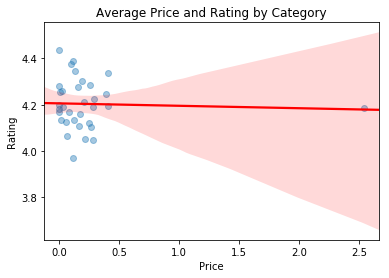

In [29]:
#show scatter plot of average rating and price for each category with regression line
sns.regplot('Price','Rating',toptable1,scatter_kws= {'alpha': 0.4},line_kws={'color':'red'})
plt.title('Average Price and Rating by Category')

Looks like that was a bit of a bust. But maybe I've looked too deep before trying to see the whole picture. I'm going to look at the distribution of all ratings vs all prices and see what becomes more apparent.

C:\Users\zgeorge\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\zgeorge\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(4.5,1.2,'All Price and Ratings & their Distributions')

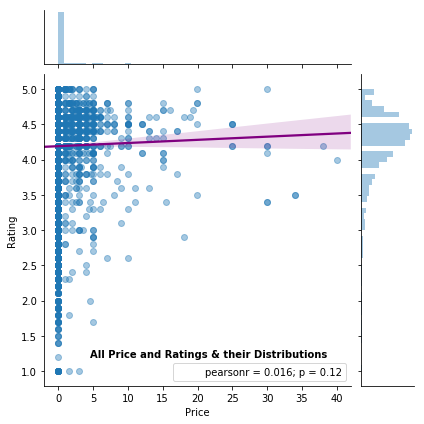

In [30]:
#Create joint plot from Price and Rating data
joint1 = sns.jointplot('Price','Rating',aapps_df,joint_kws= {'alpha': 0.4},)
#Create regression plot from same data, then overlap plots
joint2=sns.regplot('Price','Rating',aapps_df, ax=joint1.ax_joint, scatter=False,color='purple')
#despine
sns.despine()
#Place title on graph
joint2.text(4.5, 1.2, "All Price and Ratings & their Distributions", horizontalalignment='left', size='medium', color='black', weight='semibold')

We can see from the plot above that the majority of the ratings are between 5-3.5, fairly well centered on ~4.25. Then, the vast majority of the applications cost less than five dollars. There isn't a strong correlation between price and rating, but there is a slight upward trend. With so many free apps, that could potentially be affecting the distributions, so lets separate the free from the paid applications and see if the regression lines are different at this point. However, since we are doing free vs. paide, we will plot rating against number of reviews, to see if perhaps the cost affects the number of reviews pr the rating in any way.

(0, 5)

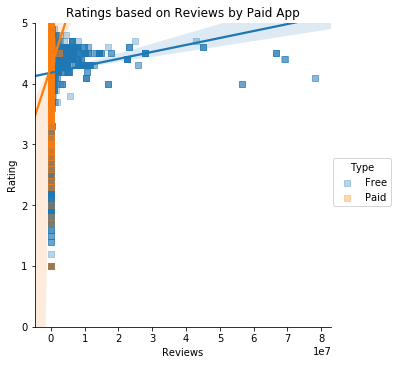

In [31]:
#Set palatte to muted
sns.color_palette(palette='muted')
#Create lmplot of Reviews and Ratings based on whether app is paid or not
sns.lmplot('Reviews','Rating',aapps_df,scatter_kws={'alpha':0.3}, markers=',',hue='Type')
#despine the plot
sns.despine()
#Set the Title of the graph from here
plt.title('Ratings based on Reviews by Paid App')
#Set the y-axis limits to a max of 5
plt.ylim(0,5)


From this graph, we can clearly see that there are far fewer reviews on the paid applications, and yet they tend to have a much higher rating per review ratio. In other words, if you want to build an app that gets high ratings without having to have as many reviews, make it paid. This likely is because people who pay for an app communicate to the developer through ratings, and if the developer is listening, they have a great incentive to fix the issues in the app.

## Section 3: Prescription Data

The opioid addiction in America is at a crisis point, and it is essential that we determine what variables are correlated with a doctor prescribing so many opioids. Although we will not be diving into that question today, we will focus on a broader scope: why do certain doctors prescribe more pills than other doctors?

We first need to read in our data that we found on Kaggle. It is in JSON and we will be reading it into our pandas dataframe.

In [32]:
#Read in the Json
rxdata = pd.read_json(r"C:\Users\zgeorge\Dropbox (CMN Hospitals)\George\School\Fall 2018\Applied Machine Learning\practice_python\Homework 1\roam_prescription_based_prediction.jsonl",lines=True)
#Print the first five rows of the json data
rxdata.head(5)

,cms_prescription_counts,npi,provider_variables
0,"{'DOXAZOSIN MESYLATE': 26, 'MIDODRINE HCL': 12...",1295763035,"{'settlement_type': 'non-urban', 'generic_rx_c..."
1,"{'CEPHALEXIN': 23, 'AMOXICILLIN': 52, 'HYDROCO...",1992715205,"{'settlement_type': 'non-urban', 'generic_rx_c..."
2,"{'CEPHALEXIN': 28, 'AMOXICILLIN': 73, 'CLINDAM...",1578587630,"{'settlement_type': 'non-urban', 'generic_rx_c..."
3,{'AMOXICILLIN': 63},1932278405,"{'settlement_type': 'non-urban', 'generic_rx_c..."
4,"{'PIOGLITAZONE HCL': 24, 'BENAZEPRIL HCL': 29,...",1437366804,"{'settlement_type': 'non-urban', 'generic_rx_c..."


Because of the focus of our investigation, namely into the providers, we will be using only the provider variables. We will flatten and normalize them, then use them as our dataframe. This will allow us to focus on them alone.

In [33]:
#Select only the provider data and flatten it
provider_data = json_normalize(data=rxdata['provider_variables'])
#Read the data into a dataframe
prvd_df = pd.DataFrame(provider_data)
#display top five rows
prvd_df.head(5)

,brand_name_rx_count,gender,generic_rx_count,region,settlement_type,specialty,years_practicing
0,384,M,2287,South,non-urban,Nephrology,7
1,0,M,103,South,non-urban,General Practice,7
2,0,M,112,Midwest,non-urban,General Practice,7
3,0,M,63,South,non-urban,General Practice,7
4,316,M,1035,West,non-urban,Nephrology,6


We need to clean the data, but first we will make sure that the data is all the correct type so that we can later analyze it.

In [34]:
#Reassign columns to the correct type of data and display data type by column
prvd_df[['region','gender','settlement_type', 'specialty']] = prvd_df[['region','gender','settlement_type', 'specialty']].astype('category')
prvd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239930 entries, 0 to 239929
Data columns (total 7 columns):
brand_name_rx_count    239930 non-null int64
gender                 239930 non-null category
generic_rx_count       239930 non-null int64
region                 239930 non-null category
settlement_type        239930 non-null category
specialty              239930 non-null category
years_practicing       239930 non-null int64
dtypes: category(4), int64(3)
memory usage: 6.6 MB


Now let's describe the data to ensure that there aren't any nulls or other issues.

In [35]:
#describe the dataset
prvd_df.describe()

,brand_name_rx_count,generic_rx_count,years_practicing
count,239930.000000,239930.000000,239930.000000
mean,176.264144,795.547047,6.241875
std,475.159281,1809.618284,1.649269
min,0.000000,0.000000,1.000000
25%,0.000000,36.000000,6.000000
50%,15.000000,145.000000,7.000000
75%,154.000000,750.000000,7.000000
max,30547.000000,101079.000000,8.000000


We look good, but the max is so much higher than the median that this concerns me. Lets visualize what that looks like. 

Text(0.5,1,'Potential Outliers in Provider Data')

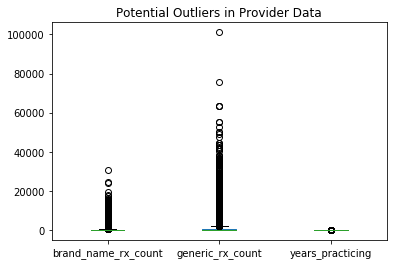

In [36]:
#display box and whisker chart for all numeric
bncountbox = prvd_df.plot(kind="box")
plt.title('Potential Outliers in Provider Data')

There are an astronomical amount of outliers. Let's find out just how many there are.

In [37]:
#define the 25th and 75th percentile
q_df = prvd_df.quantile([.25, .75])
#Determine the IQR
q_df.loc['iqr'] = q_df.loc[0.75] - q_df.loc[0.25]
#Define whisker length as 1.5 times the IQR
q_df.loc['whisker_length'] = 1.5 * q_df.loc['iqr']
#Define max whisker length as the sum of the whisker length and the 75th percentile
q_df.loc['max_whisker'] = q_df.loc['whisker_length'] + q_df.loc[0.75]
#Define min whisker length as the differnec of the whisker length and the 25th percentile
q_df.loc['min_whisker'] = q_df.loc[0.25] - q_df.loc['whisker_length']
#Print the number of outlers in the brand name perscriptions
max_outlier_bnrxcount = [brandnames for brandnames in prvd_df['brand_name_rx_count'] if brandnames > q_df['brand_name_rx_count'].loc['max_whisker']]
print("brand_name_rx_count Outliers")
print(len(max_outlier_bnrxcount))
#Print the number of outlers in the brand name perscriptions
max_outlier_genrxcount = [generics for generics in prvd_df['generic_rx_count'] if generics > q_df['generic_rx_count'].loc['max_whisker']]
print("generic_rx_count Outliers")
print(len(max_outlier_genrxcount))

brand_name_rx_count Outliers
31412
generic_rx_count Outliers
30496


Although we would normally drop them, these are not incorrectly identified, and we are interested in seeing what causes them to be so high. Another couple of variables we are interested in are the ratio of Brand name to generic prescriptions written, as perhaps doctors are getting kickbacks from Big Pharma, and lastly what is the total amount of prescriptions written. So lets make those two new variables and add them to our dataframe.

In [38]:
#Create a new column in the df that is a ratio of brand name prescriptions to generic perscriptions
prvd_df['bn_to_gen'] = prvd_df['brand_name_rx_count'] / prvd_df['generic_rx_count']
#Create a new column in the df that is a total count of prescriptions
prvd_df['total_rx_count'] = prvd_df['brand_name_rx_count'] + prvd_df['generic_rx_count']
#Print first 5 rows of dataframe with new columns
prvd_df.head(5)

,brand_name_rx_count,gender,generic_rx_count,region,settlement_type,specialty,years_practicing,bn_to_gen,total_rx_count
0,384,M,2287,South,non-urban,Nephrology,7,0.167906,2671
1,0,M,103,South,non-urban,General Practice,7,0.000000,103
2,0,M,112,Midwest,non-urban,General Practice,7,0.000000,112
3,0,M,63,South,non-urban,General Practice,7,0.000000,63
4,316,M,1035,West,non-urban,Nephrology,6,0.305314,1351


Now that our dataframe is ready, lets go ahead and see if any correlations emerge.

In [39]:
#Print correlation between each variable
prvd_df.corr()

,brand_name_rx_count,generic_rx_count,years_practicing,bn_to_gen,total_rx_count
brand_name_rx_count,1.000000,0.790673,0.129440,0.176963,0.864548
generic_rx_count,0.790673,1.000000,0.121950,-0.000851,0.991255
years_practicing,0.129440,0.121950,1.000000,0.056737,0.128000
bn_to_gen,0.176963,-0.000851,0.056737,1.000000,0.037445
total_rx_count,0.864548,0.991255,0.128000,0.037445,1.000000


Nothing in particular pops out of the correlation analysis. Perhaps we can feel confident that Big Pharma isn't the main reason as the correlation between total prescriptions and generic prescriptions is so high. However, because there has been a large push on reducing the number of prescriptions given out in the last several years, lets check there first.

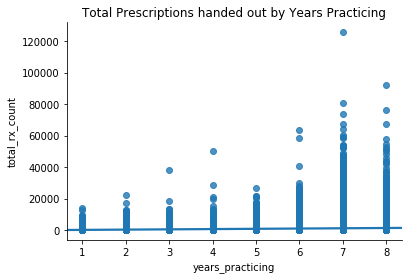

In [40]:
plot = sns.regplot('years_practicing','total_rx_count',prvd_df)
plt.title('Total Prescriptions handed out by Years Practicing')
sns.despine()

This plot gives a pretty convincing argument, but maybe there is more to the story. Lets add in gender and see if it paints a different picture.

In [ ]:
plot = sns.lmplot('years_practicing','total_rx_count',prvd_df,hue='gender')
plt.title('Total Prescriptions by Years Practicing & Gender')

This doesn't appear to strongly change the correlation. What if we tested for the area of the country?

In [ ]:
plot = sns.lmplot('years_practicing','total_rx_count',prvd_df,hue='region')
plt.title('Total Prescriptions by Years Practicing & Practice Region')

Again, not much more information. For our last try, let's look at the environment in which the practicioner is prescribing and see if there is any noticable effects.

In [ ]:
plot = sns.lmplot('years_practicing','total_rx_count',prvd_df,hue='settlement_type')
plt.title('Total Prescriptions by Years Practicing & Practice Eviron')

One noticable aspect of this chart is that the top provider in almost every year is in a non-urban environment. More analysis would have to be proformed to conclusively decided that this is an important aspect. However, as we can see, the seemingly most important aspect of the those that are providing too many prescriptions is the amount of years that they have been practicing. We cannot say conclusively that this is due to the practice of teaching to provide fewer prescriptions, but the initial analysis suggests that those who have been in school more recently, provide fewer prescriptions.